### 1. 로지스틱 회귀 2. knn  3. SVM

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [2]:
df = pd.DataFrame({
    "customer":  [f"고객{i}" for i in range(1, 13)],
    "sales":     [100, 120, 130, 140, 150, 200, 220, 180, 190, 200, 210, 120],
    "income":    [10, 12, 13, 14, 15, 16, 17, 20, 22, 19, 20, 22],
    "interest":  [1.2, 1.5, 1.4, 1.3, 1.4, 1.5, 1.4, 1.4, 1.4, 1.5, 1.5, 1.5],
    "loans": [100, 105, 102, 103, 104, 104, 105, 105, 103, 102, 104, 105],
    "status": [
        "정상", "정상", "연체", "정상", "정상", "정상",
        "정상", "정상", "정상", "정상", "연체", "연체"
    ]
})

df

,customer,sales,income,interest,loans,status
0,고객1,100,10,1.2,100,정상
1,고객2,120,12,1.5,105,정상
2,고객3,130,13,1.4,102,연체
3,고객4,140,14,1.3,103,정상
4,고객5,150,15,1.4,104,정상
5,고객6,200,16,1.5,104,정상
6,고객7,220,17,1.4,105,정상
7,고객8,180,20,1.4,105,정상
8,고객9,190,22,1.4,103,정상
9,고객10,200,19,1.5,102,정상


#### # 타깃 인코딩: 정상=0, 연체=1

In [3]:



df["y"] = df["status"].map({"정상": 0, "연체": 1})

X = df[["sales", "income", "interest", "loans"]]
y = df["y"]


#### Train/Test 분할 (7:3) + 스케일링

In [4]:
# kNN/SVM은 스케일링 필수, 로지스틱도 함께 적용해 공정 비교

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc  = scaler.transform(X_test)


#### 모델 학습

In [6]:
# 1) 로지스틱 회귀
logit = LogisticRegression()
logit.fit(X_train_sc, y_train)

# 2) KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_sc, y_train)

# 3) SVM
svm = SVC(kernel="rbf", C=1.0, gamma="scale")
svm.fit(X_train_sc, y_train)


SVC()

#### 예측 & 혼동행렬 (표로 보기)

In [7]:
models = {
    "Logistic": logit,
    "KNN": knn,
    "SVM": svm
}

def cm_table(y_true, y_pred, name):
    cm = confusion_matrix(y_true, y_pred)
    return pd.DataFrame(
        cm,
        index=["Actual 정상", "Actual 연체"],
        columns=["Pred 정상", "Pred 연체"]
    ).assign(Model=name)

tables = []
for name, model in models.items():
    y_pred = model.predict(X_test_sc)
    tables.append(cm_table(y_test, y_pred, name))

cm_results = pd.concat(tables)
cm_results


,Pred 정상,Pred 연체,Model
Actual 정상,3,0,Logistic
Actual 연체,1,0,Logistic
Actual 정상,3,0,KNN
Actual 연체,1,0,KNN
Actual 정상,3,0,SVM
Actual 연체,1,0,SVM


In [8]:
# 로지스틱: 해석 용이, 기준선 모델

# KNN: 거리 기반 → 스케일링 중요

# SVM: 비선형 경계 강점, 소표본에서도 강력

#### 각 모델의 정확도/정밀도/재현율/F1 비교표

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# 모델별 성능 지표 계산
# 양성 클래스(positive class) = 연체(1)
# → average="binary" 기본값 사용

results = []

for name, model in models.items():
    y_pred = model.predict(X_test_sc)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred)
    })

metrics_df = pd.DataFrame(results)
metrics_df


C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\JYB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

,Model,Accuracy,Precision,Recall,F1-score
0,Logistic,0.75,0.0,0.0,0.0
1,KNN,0.75,0.0,0.0,0.0
2,SVM,0.75,0.0,0.0,0.0


In [10]:
# 지표 해석 가이드 (연체 예측 기준)
# 지표	의미	금융 해석
# Accuracy	전체 맞춘 비율	⚠️ 불균형 데이터에 취약
# Precision	연체로 예측한 것 중 진짜 연체	불필요한 차단 감소
# Recall	실제 연체 중 잡아낸 비율	⭐ 가장 중요
# F1-score	Precision·Recall 균형	종합 성능

### Iris 데이터셋 (이진 분류로 단순화)

- 데이터 생성 → 학습 → 혼동행렬

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


In [26]:
# 겹침이 있는 이진 분류 데이터 생성
X, y = make_classification(
    n_samples=500,
    n_features=5,
    n_informative=3,
    n_redundant=1,
    n_clusters_per_class=2,
    class_sep=0.8,     # 작을수록 겹침 증가
    flip_y=0.1,        # 라벨 노이즈 (10%)
    random_state=42
)

# 학습 / 테스트 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 표준화
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [27]:
# 모델 정의 : 3가지 모델

In [28]:
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "SVM (RBF)": SVC(kernel="rbf")
}


In [29]:
# 평가 함수 (지표 + 혼동행렬)

In [30]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n=== {name} ===")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")

    ConfusionMatrixDisplay(cm).plot()
    plt.title(name)
    plt.show()


In [ ]:
# 학습 및 결과 확인

In [ ]:
# models : 앞에서 정의한 딕셔너리
# models.items() :딕셔너리에서 (key, value) 쌍을 하나씩 꺼내는 메서드
# for name, model in models.items():models 안에 있는 모든 모델에 대해 모델 이름은 name으로, 모델 객체는 model로 하나씩 꺼내라
# model.fit(X_train, y_train) : 학습 단계, X_train : 입력 데이터 (특성), y_train : 정답 라벨
# evaluate_model(name, model) : 평가 함수 호출, 앞에서 정의한 함수


=== Logistic Regression ===
Confusion Matrix:
[[64 13]
 [17 56]]
Accuracy : 0.800
Precision: 0.812
Recall   : 0.767
F1-score : 0.789


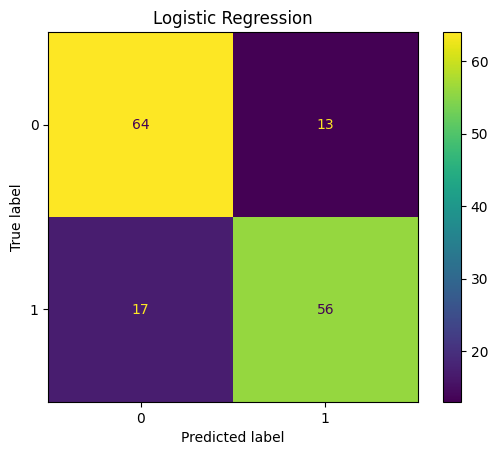


=== KNN (k=7) ===
Confusion Matrix:
[[65 12]
 [12 61]]
Accuracy : 0.840
Precision: 0.836
Recall   : 0.836
F1-score : 0.836


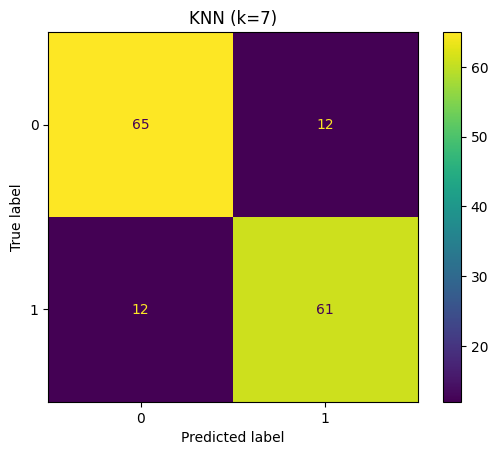


=== SVM (RBF) ===
Confusion Matrix:
[[66 11]
 [11 62]]
Accuracy : 0.853
Precision: 0.849
Recall   : 0.849
F1-score : 0.849


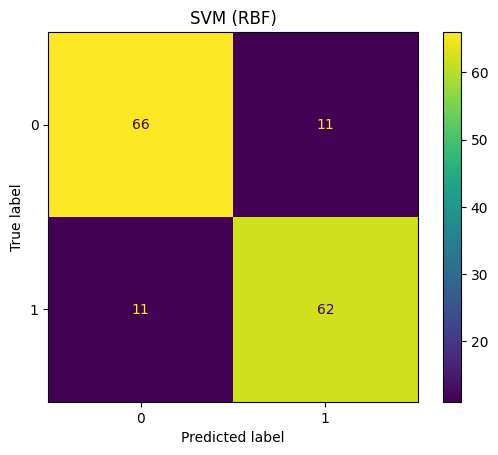

In [31]:
for name, model in models.items():
    model.fit(X_train, y_train)
    evaluate_model(name, model)
